---
title: "强化学习专题 - 蒙特卡洛强化学习"
date: 2025-06-06T23:22:00+08:00
author: "Liu Zheng"
tags: ["笔记", "实验", "AI", "强化学习"]
categories: "实验笔记"
---

# 蒙特卡洛强化学习

蒙特卡洛方法是一种通过对环境进行多次采样，利用样本平均来估计状态或动作价值的方法。它不依赖于环境的完整模型，而是基于实际经验轨迹进行学习，适用于模型未知或难以建模的情形。

> **注意**：蒙特卡洛强化学习（Monte Carlo Reinforcement Learning） 和 蒙特卡洛树搜索（Monte Carlo Tree Search, MCTS） 是不同的算法体系，尽管它们都用到了“蒙特卡洛”思想（即基于采样的方法进行估计），但目的、适用场景和方法结构都有显著区别：
> 
> | 维度 | 蒙特卡洛强化学习 | 蒙特卡洛树搜索（MCTS） |
> | --- | --- | --- |
> | 应用领域 | 强化学习（RL），估计策略价值或学习最优策略 | 搜索问题，特别是博弈（如围棋、象棋） |
> | 目标 | 学习最优策略或状态-动作值函数（Q值） | 在给定状态下选择最优动作 |
> | 主要思想 | 通过多次完整的 episode 采样来估计期望回报 | 通过模拟和树状搜索估计每个动作的潜在价值 |
> | 是否建树 | 否 | 是（构建一个状态-动作搜索树） |
> | 是否使用值函数 | 是，学习 $V(s)$ 或 $Q(s, a)$ | 通常不直接学习函数值，而是统计平均回报 |


## 1. 数学原理

> **算法实现**
> 
> $
> \begin{array}{l}
> input:\  \text{MDP}\ = \{ S, A, s_0, P_a(s' \mid s), R(s,a,s')\}\\
> output:\ \text{Q-function}\ Q\\[4mm]
> \text{Initialise}\ Q\ \text{arbitrarily;}\\
> Q(s, a) \leftarrow 0\ \text{for all}\ s\ \text{and}\ a, N(s, a) \leftarrow 0\ \text{for all}\ s\ \text{and}\ a\\[4mm]
> repeat \\
> \quad\quad \text{Generate an episode}\ (s_0, a_0, r_1, \ldots, s_{T-1}, a_{T-1}, r_T);\\
> \quad\quad\quad\quad \text{e.g. using}\ Q\ \text{and a multi-armed bandit algorithm such as}\ \epsilon\text{-greedy}\\
> \quad\quad G \leftarrow 0, t \leftarrow T-1\\
> \quad\quad while\ t \geq 0\ do\\
> \quad\quad\quad\quad G \leftarrow R_{t+1} + \gamma \cdot G\\
> \quad\quad\quad\quad if\ s_t, a_t\ \text{does not appear in}\ s_0, a_0,\ldots, s_{t-1}, a_{t-1}\ then\\
> \quad\quad\quad\quad\quad\quad Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \frac{1}{N(s_t, a_t)}[G - Q(s_t, a_t)], N(s_t, a_t) \leftarrow N(s_t, a_t) + 1\\
> \quad\quad\quad\quad t \leftarrow t-1\\
> until\ Q\ \text{converges}
> \end{array}
> $

## 2. 案例场景

我们同样选择 Frozen Lake 场景作为训练场景。

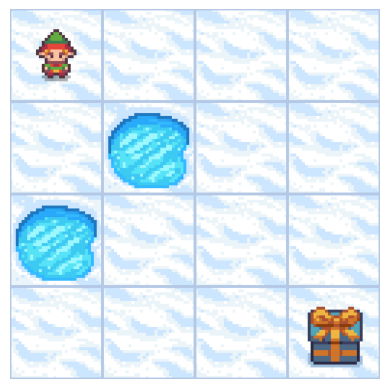

In [1]:
import gymnasium
import matplotlib.pyplot
import numpy
from collections import defaultdict
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

SIZE = 4
FONT = "Sarasa Fixed SC"

ENV = gymnasium.make("FrozenLake-v1", desc=generate_random_map(SIZE), map_name=f"{SIZE}x{SIZE}", is_slippery=False, render_mode="rgb_array")
ENV.reset()

image = ENV.render()

matplotlib.pyplot.imshow(image)
matplotlib.pyplot.axis("off")
matplotlib.pyplot.show()

### 2.1. ε-greedy 策略解释

ε-greedy（ε-贪婪）策略是一种在强化学习中平衡“探索”（exploration）与“利用”（exploitation）的方法。其核心思想是：

- 以概率 $1-\epsilon$ 选择当前已知价值最高的动作（贪婪选择，exploitation）。
- 以概率 $\epsilon$ 随机选择一个动作（探索，exploration），以发现潜在更优的策略。

这样可以避免陷入局部最优，提升学习效率。$\epsilon$ 通常会随训练进程逐步减小，前期更多探索，后期更多利用已学到的知识。

### 2.2. 稀疏价值网络带来的问题

在像 Frozen Lake 这样奖励极其稀疏的环境中，只有到达终点才会获得奖励，大部分状态-动作对的回报为零。这会导致：

- 许多 $(s, a)$ 对很难被采样到有效回报，$Q(s, a)$ 长时间保持初始值，学习进展缓慢。
- 由于回报稀疏，$Q$ 的估计方差大，收敛速度慢，甚至可能陷入局部最优。
- 需要大量 episode 才能覆盖所有有意义的状态-动作对，样本效率低。

**解决思路**：  
- 增加探索（如更高的 $\epsilon$），提升采样多样性。
- 引入奖励塑形（reward shaping）或利用先验知识辅助学习。
- 结合其他方法（如 TD 学习、Dyna 等）提升稠密性和收敛速度。

具体到下方的编程，由于 `FrozenLake-v1` 价值网络属于极端稀疏价值网络（只有终点存在奖励 1.0）因此做了如下措施：

探索率随着探索次数 `epi` 指数衰减，这样可以增强初期随机性：

```python
def choose_action(self, s, epi):
    if numpy.random.rand() < max(0.1, 0.995**epi):
        return self.env.action_space.sample()
    return numpy.argmax(self.Qt[s])
```

> **算法实现**
> 
> $
> \begin{array}{l}
> input:\  \text{MDP}\ = \{ S, A, s_0, P_a(s' \mid s), R(s,a,s')\}\\
> output:\ \text{Q-function}\ Q\\[4mm]
> \text{Initialise}\ Q\ \text{arbitrarily;}\\
> Q(s, a) \leftarrow 0\ \text{for all}\ s\ \text{and}\ a, N(s, a) \leftarrow 0\ \text{for all}\ s\ \text{and}\ a\\[4mm]
> \text{repeat episodes}\\
> \quad\quad \text{Generate an episode}\ (s_0, a_0, r_1, \ldots, s_{T-1}, a_{T-1}, r_T);\\
> \quad\quad\quad\quad \text{e.g. using}\ Q\ \text{and a multi-armed bandit algorithm such as}\ \epsilon\text{-greedy}\\
> \quad\quad G \leftarrow 0, t \leftarrow T-1\\
> \quad\quad while\ t \geq 0\ do\\
> \quad\quad\quad\quad G \leftarrow R_{t+1} + \gamma \cdot G\\
> \quad\quad\quad\quad if\ s_t, a_t\ \text{does not appear in}\ s_0, a_0,\ldots, s_{t-1}, a_{t-1}\ then\\
> \quad\quad\quad\quad\quad\quad Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \frac{1}{N(s_t, a_t)}[G - Q(s_t, a_t)], N(s_t, a_t) \leftarrow N(s_t, a_t) + 1\\
> \quad\quad\quad\quad t \leftarrow t-1\\
> \end{array}
> $

In [2]:
class MCMDP:
    def __init__(self, env):
        self.env = env
        self.S = range(env.observation_space.n)
        self.A = range(env.action_space.n)
        self.Qt = defaultdict(lambda: numpy.zeros(env.action_space.n))
        self.Nt = defaultdict(lambda: numpy.zeros(env.action_space.n))

    def choose(self, s, cp=1.0):
        Ns = numpy.sum(self.Nt[s])
        if Ns == 0:
            return self.env.action_space.sample()
        ucbv = numpy.zeros(self.env.action_space.n)
        for a in self.A:
            Nsa = self.Nt[s][a]
            if Nsa == 0:
                return a
            ucbv[a] = self.Qt[s][a] + 2 * cp * numpy.sqrt(2 * numpy.log(Ns) / Nsa)
        return numpy.argmax(ucbv)

    def next(self, s, a):
        sn, Rsa, done, truncated, _ = self.env.step(a)
        if done and Rsa == 1.0:
            return sn, Rsa, done, truncated
        if done and Rsa == 0.0:
            return sn, -1.0, done, truncated
        if truncated:
            return sn, -0.1, done, truncated
        sx, sy = s // SIZE, s % SIZE
        snx, sny = sn // SIZE, sn % SIZE
        phis = 1.0 - (abs(sx - SIZE + 1) + abs(sy - SIZE + 1)) / (2 * SIZE - 2)
        phisn = 1.0 - (abs(snx - SIZE + 1) + abs(sny - SIZE + 1)) / (2 * SIZE - 2)
        return sn, Rsa + 0.99 * phisn - phis, done, truncated

    def episode(self):
        T = []
        s, _ = self.env.reset()
        done, truncated = False, False
        while not done and not truncated:
            a = self.choose(s)
            sn, Rsa, done, truncated = self.next(s, a)
            T.append((s, a, Rsa))
            s = sn
        return T

    def build(self, gamma=0.99, epis=1000):
        for epi in range(epis):
            T = self.episode()
            G = 0
            visited = set()
            for st, at, Rsa in reversed(T):
                G = Rsa + gamma * G
                if (st, at) not in visited:
                    visited.add((st, at))
                    self.Nt[st][at] += 1
                    Q = self.Qt[st][at]
                    self.Qt[st][at] += (1 / self.Nt[st][at]) * (G - Q)

    def decision(self, s):
        return int(numpy.argmax(self.Qt[s])), numpy.max(self.Qt[s])

    def evaluate(self, figure):
        image = self.env.render()
        subplot = figure.add_subplot()
        subplot.axis("off")
        subplot.imshow(image)
        ih, iw, _ = image.shape
        ch, cw = ih // SIZE, iw // SIZE  # Cell height and width
        s, _ = self.env.reset()
        for i in range(SIZE):
            for j in range(SIZE):
                Qs0 = self.Qt[i * SIZE + j][0]
                Qs1 = self.Qt[i * SIZE + j][1]
                Qs2 = self.Qt[i * SIZE + j][2]
                Qs3 = self.Qt[i * SIZE + j][3]
                subplot.text(j * cw + cw - 36, i * ch + 12, f"L:{Qs0: >5.2f}", fontsize=8, fontfamily=FONT)
                subplot.text(j * cw + cw - 36, i * ch + 24, f"D:{Qs1: >5.2f}", fontsize=8, fontfamily=FONT)
                subplot.text(j * cw + cw - 36, i * ch + 36, f"R:{Qs2: >5.2f}", fontsize=8, fontfamily=FONT)
                subplot.text(j * cw + cw - 36, i * ch + 48, f"U:{Qs3: >5.2f}", fontsize=8, fontfamily=FONT)
        while True:
            a, _ = self.decision(s)
            s, _, done, truncated = self.next(s, a)
            if done or truncated:
                break
            subplot.plot(s % SIZE * cw + cw // 2, s // SIZE * ch + ch // 2, marker="o", markersize=8, color="red", alpha=0.5)
        matplotlib.pyplot.show()

    def simulation(self, epis=100):
        count = 0
        for episode in range(epis):
            s, _ = self.env.reset()
            done, truncated = False, False
            while not done and not truncated:
                a, _ = self.decision(s)
                s, Rs, done, truncated = self.next(s, a)
                if done and Rs == 1.0:
                    count += 1
        success_rate = count / epis * 100
        print(f"\nRunning {epis} episodes using the optimal policy:")
        print(f"Success Rate: {success_rate:.2f}%")

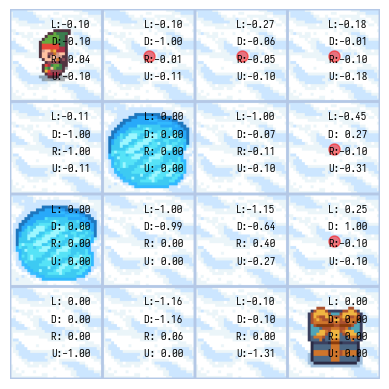


Running 100 episodes using the optimal policy:
Success Rate: 100.00%


In [3]:
INSTANCE = MCMDP(ENV)
INSTANCE.build()
INSTANCE.evaluate(matplotlib.pyplot.figure())
INSTANCE.simulation()